# GeoPython Week - exercise 2
## Table of Contents
- [Define interval](#interval)
- [Split: Train - Validation - Test](#split)
- [Pipeline](#pipeline)

In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

# for managing class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

import pickle
import os
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# create folder to save models
models_loc='models7wells_2d_2/'
if not os.path.exists(models_loc):
    os.makedirs(models_loc)

In [3]:
# define parameters
interval= True
#interval= False
imbalance = True
#imbalance = False
WS_level=0.9
make_gridsearch=True
make_kfold=True
K_folds=5

In [4]:
# read data
#logs=pd.read_csv('data_cleaned1/logs_combined.csv')
logs = pd.read_csv("Data/logs_7wells.csv")
stack_logs=pd.read_csv('data/seismic_7wells.csv')
stack_section2=pd.read_csv('data/section_2D_2.csv')



In [5]:
logs

,Time,Density,P_wave,Porosity,V_clay,Water Saturation,log_ID,Horison,Imp
0,514.8757,1.2545,1577.8733,0.0557,0.4820,1.0,6507_2-1,2D-mid,1979.442055
1,515.0686,1.2542,1579.8525,0.0550,0.4766,1.0,6507_2-1,2D-mid,1981.451006
2,515.2613,1.2724,1581.8326,0.0579,0.5014,1.0,6507_2-1,2D-mid,2012.723800
3,515.4538,1.2821,1583.8119,0.0592,0.5126,1.0,6507_2-1,2D-mid,2030.605237
4,515.6460,1.2897,1585.7920,0.0601,0.5201,1.0,6507_2-1,2D-mid,2045.195942
...,...,...,...,...,...,...,...,...,...
75753,2811.0000,2.7140,5309.3721,0.0456,0.3905,1.0,6507_6-4A,NaN,14409.635879
75754,2815.0000,2.7070,5222.0928,0.0385,0.3188,1.0,6507_6-4A,NaN,14136.205210
75755,2819.0000,2.6720,5222.0928,0.0523,0.3061,1.0,6507_6-4A,NaN,13953.431962
75756,2823.0000,2.6814,5222.0928,0.0454,0.3267,1.0,6507_6-4A,NaN,14002.519634


In [6]:
stack_section2

,Time,Imp,Trace,Porosity,Density,V_clay,P_wave,Seismic
0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.656821
1,4,0.0,1.0,0.0,0.0,1.0,0.0,1.242430
2,8,0.0,1.0,0.0,0.0,1.0,0.0,1.123410
3,12,0.0,1.0,0.0,0.0,1.0,0.0,0.482746
4,16,0.0,1.0,0.0,0.0,1.0,0.0,0.078466
...,...,...,...,...,...,...,...,...
714091,2184,0.0,1296.0,0.0,0.0,1.0,0.0,NaN
714092,2188,0.0,1296.0,0.0,0.0,1.0,0.0,NaN
714093,2192,0.0,1296.0,0.0,0.0,1.0,0.0,NaN
714094,2196,0.0,1296.0,0.0,0.0,1.0,0.0,NaN


In [7]:
seismic_att_names=['Time','AmpEnv', 'AppPolr', 'AWCP', 'AWF', 'Der',
       'DomF', 'InstF', 'Integrated', 'QuadrTrace', 'SecDer', 'SecDerInstAmpl', 
       'Seismic']

## Creating  Sweetness Attribute

In [8]:
sqrInsF = stack_logs['InstF'] *stack_logs['InstF']
sqrInsF
InF = np.sqrt(sqrInsF)
sqrtInsF = np.sqrt(InF)

sweetness = stack_logs['AmpEnv']/sqrtInsF
sweetness
stack_logs['Sweetness'] = sweetness
#stack_logs.loc[stack_logs['InstF'] <0,'Sweetness'] = stack_logs.loc[stack_logs['InstF'] <0,'Sweetness'] * -1 
stack_logs

,Time,Seismic,log_ID,QuadrTrace,SecDerInstAmpl,Integrated,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness
0,0.0,1.857250e-07,6507_2-4,0.0,0.000003,-1.458270e-07,-0.002556,-3.714510e-08,0.435150,11.2305,0.587815,0.000000e+00,0.002723,0.002723,0.003551
1,4.0,1.485800e-07,6507_2-4,0.0,0.000003,2.364560e-08,-0.002496,-3.714510e-08,0.424978,11.2305,-0.586274,0.000000e+00,0.002651,0.002651,0.003462
2,8.0,-4.952680e-08,6507_2-4,0.0,0.000003,-2.943440e-09,-0.002478,-1.981070e-07,0.421835,11.2305,0.573187,-1.609620e-07,0.002629,0.002629,0.003472
3,12.0,1.981070e-07,6507_2-4,0.0,-0.000003,2.088340e-07,-0.002418,2.476340e-07,0.411794,11.2305,-0.576099,4.457410e-07,0.002558,0.002558,0.003371
4,16.0,5.262220e-08,6507_2-4,0.0,0.000003,2.766920e-07,-0.002399,-1.454850e-07,0.408441,11.2305,0.564944,-3.931190e-07,0.002535,0.002535,0.003373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5674,3156.0,-1.701137e-02,6507_5-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5675,3160.0,1.495743e-02,6507_5-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5676,3164.0,4.436120e-02,6507_5-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5677,3168.0,5.590646e-02,6507_5-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#logs.describe()

In [10]:
#l = logs[(logs['Time']>=2640) & (logs['Time']<=2850)].reset_index(drop=True)
    
#l

In [11]:
#logs

<a id='interval'></a>
## Train algorithms on small interwal 

 . |6507/3-6 | 6507/6-4A | 6507/5-5 | 6507/3-9S | 6507/2-4 | 6507/2-2 | 6507/2-1
 ---|---|---|---|---|---|---|---				
from| 1300| 1050| 2585| 2650| 2670| 2666| 2674
to| 1352| 1200| 2734| 2800 |2800 |2800 |2840

In [242]:
# select df only in this intervals
if interval==True:

    sub_logs=logs[(logs['log_ID']=='6507_3-6') & (logs['Time']>=1300) & (logs['Time']<=1352)].append(
        logs[(logs['log_ID']=='6507_6-4A') & (logs['Time']>=1050) & (logs['Time']<=1200)]).append(
        logs[(logs['log_ID']=='6507_5-5') & (logs['Time']>=2585) & (logs['Time']<=2734)]).append(
        logs[(logs['log_ID']=='6507_3-9s') & (logs['Time']>=2650) & (logs['Time']<=2800)]).append(
        logs[(logs['log_ID']=='6507_2-4') & (logs['Time']>=2670) & (logs['Time']<=2800)]).append(
        logs[(logs['log_ID']=='6507_2-2') & (logs['Time']>=2666) & (logs['Time']<=2800)]).append(
        logs[(logs['log_ID']=='6507_2-1') & (logs['Time']>=2674) & (logs['Time']<=2840)]).reset_index(drop=True)
   
    if imbalance == True:
        sub_logs = logs[(logs['Time']>=2585) & (logs['Time']<=2840)].append(
        logs[(logs['log_ID']=='6507_3-6') & (logs['Time']>=1300) & (logs['Time']<=1352)]).append(
        logs[(logs['log_ID']=='6507_6-4A') & (logs['Time']>=1050) & (logs['Time']<=1200)]).reset_index(drop=True)
        sub_logs = logs[(logs['Time']>=1050) & (logs['Time']<=2850)].reset_index(drop=True)
    
else:
    # select df only in this intervals

    sub_logs=logs[(logs['Horison']=='2D-K65') | (logs['Horison']=='2D-BCU')| 
         (logs['Horison']=='2D-bottom')| (logs['Horison'].isna())]

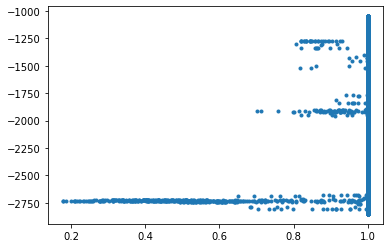

In [243]:
plt.plot(sub_logs['Water Saturation'],-sub_logs['Time'],  '.')

In [244]:
(sub_logs['Water Saturation']<0.9).sum(), sub_logs.shape[0]

(450, 49531)

2 additional well on proposed intervals don't have oil (Water Saturation==1). log'6507_5-5' has oil on 3230 up to 3266

In [245]:
logs[(logs['log_ID']=='6507_5-5') & (logs['Water Saturation']<1.0)]

,Time,Density,P_wave,Porosity,V_clay,Water Saturation,log_ID,Horison,Imp
75158,3230.0,2.6212,86.1755,0.0860,0.7564,0.9974,6507_5-5,NaN,225.883221
75159,3234.0,2.3672,79.2598,0.1682,0.0545,0.0815,6507_5-5,NaN,187.623799
75160,3238.0,2.3693,75.4672,0.1604,0.0602,0.0448,6507_5-5,NaN,178.804437
75161,3242.0,2.3687,75.4699,0.1601,0.0652,0.0504,6507_5-5,NaN,178.765552
75162,3246.0,2.4287,71.4300,0.1256,0.0670,0.1406,6507_5-5,NaN,173.482041
75163,3250.0,2.4472,71.0303,0.1153,0.0696,0.2849,6507_5-5,NaN,173.825350
75164,3254.0,2.3816,77.9391,0.1602,0.0745,0.2734,6507_5-5,NaN,185.619761
75165,3258.0,2.3854,77.4561,0.1585,0.0620,0.2992,6507_5-5,NaN,184.763781
75166,3262.0,2.4949,76.2368,0.0853,0.3599,0.9099,6507_5-5,NaN,190.203192
75167,3266.0,2.6242,71.8005,0.0526,0.3944,0.9964,6507_5-5,NaN,188.418872


### Moving average

In [246]:
#stack_logs[stack_logs['log_ID']=='6507_2-1'][['Time', 'Stack']]
def opposite_mov_avg(data):
    
    data_1=(data+data.shift(1))/2
    data_1=data.append(data_1.dropna()).sort_values('Time').reset_index(drop=True)
    data_2=(data_1+data_1.shift(1))/2
    data_2=data_1.append(data_2.dropna()).sort_values('Time').reset_index(drop=True)
    return data_2

#stack_logs_extra_points=opposite_mov_avg(stack_logs[stack_logs['log_ID']=='6507_2-1'][['Time', 'Seismic']])
#stack_logs_extra_points=opposite_mov_avg(stack_logs)
#stack_logs_extra_points
stack_logs
#stack_logs[stack_logs['log_ID']==log_id][['Time', 'Seismic']]

,Time,Seismic,log_ID,QuadrTrace,SecDerInstAmpl,Integrated,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness
0,0.0,1.857250e-07,6507_2-4,0.0,0.000003,-1.458270e-07,-0.002556,-3.714510e-08,0.435150,11.2305,0.587815,0.000000e+00,0.002723,0.002723,0.003551
1,4.0,1.485800e-07,6507_2-4,0.0,0.000003,2.364560e-08,-0.002496,-3.714510e-08,0.424978,11.2305,-0.586274,0.000000e+00,0.002651,0.002651,0.003462
2,8.0,-4.952680e-08,6507_2-4,0.0,0.000003,-2.943440e-09,-0.002478,-1.981070e-07,0.421835,11.2305,0.573187,-1.609620e-07,0.002629,0.002629,0.003472
3,12.0,1.981070e-07,6507_2-4,0.0,-0.000003,2.088340e-07,-0.002418,2.476340e-07,0.411794,11.2305,-0.576099,4.457410e-07,0.002558,0.002558,0.003371
4,16.0,5.262220e-08,6507_2-4,0.0,0.000003,2.766920e-07,-0.002399,-1.454850e-07,0.408441,11.2305,0.564944,-3.931190e-07,0.002535,0.002535,0.003373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5674,3156.0,-1.701137e-02,6507_5-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5675,3160.0,1.495743e-02,6507_5-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5676,3164.0,4.436120e-02,6507_5-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5677,3168.0,5.590646e-02,6507_5-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [247]:
count=0
stack_logs_extra_points=[]
for log_id in stack_logs['log_ID'].value_counts().index.to_list():
    
    df_extra_points=opposite_mov_avg(stack_logs[stack_logs['log_ID']==log_id][['Time', 'Seismic']])
    df_extra_points['log_ID']=log_id
    
    if count==0:
        stack_logs_extra_points=df_extra_points
    else:
        stack_logs_extra_points=stack_logs_extra_points.append(df_extra_points)
    
    count=count+1

In [248]:
sub_logs

,Time,Density,P_wave,Porosity,V_clay,Water Saturation,log_ID,Horison,Imp
0,1050.0450,2.0322,2190.8054,0.0776,0.6714,1.0,6507_2-1,2D-mid,4452.154734
1,1050.1869,2.0291,2181.9836,0.0783,0.6776,1.0,6507_2-1,2D-mid,4427.462923
2,1050.3293,2.0260,2173.2310,0.0790,0.6839,1.0,6507_2-1,2D-mid,4402.966006
3,1050.4731,2.0009,2151.1841,0.0776,0.6716,1.0,6507_2-1,2D-mid,4304.304266
4,1050.6184,1.9758,2129.5786,0.0762,0.6593,1.0,6507_2-1,2D-mid,4207.621398
...,...,...,...,...,...,...,...,...,...
49526,2811.0000,2.7140,5309.3721,0.0456,0.3905,1.0,6507_6-4A,NaN,14409.635879
49527,2815.0000,2.7070,5222.0928,0.0385,0.3188,1.0,6507_6-4A,NaN,14136.205210
49528,2819.0000,2.6720,5222.0928,0.0523,0.3061,1.0,6507_6-4A,NaN,13953.431962
49529,2823.0000,2.6814,5222.0928,0.0454,0.3267,1.0,6507_6-4A,NaN,14002.519634


## Opposite Moving Average and Moving Average Implementation

In [249]:
opp_mov_avg=False
if opp_mov_avg==True:
    sub_logs['Time_rounded']=np.round(sub_logs['Time']/1)*1
    sub_logs=sub_logs.groupby(['log_ID','Time_rounded']).mean().reset_index().drop('Time', axis=1).rename(columns={'Time_rounded': 'Time'})
    sub_logs['Target']=0
    sub_logs.loc[sub_logs['Water Saturation']<=0.95, 'Target']=1
    
    log_seismic_df=pd.merge(sub_logs,stack_logs_extra_points, how='inner', on=['log_ID','Time']).sort_values(['log_ID','Time'])
    

else: 
    sub_logs_av = sub_logs
    sub_logs_av['Time_rounded'] = np.round(sub_logs_av['Time']/4)*4
    horison_vect = sub_logs_av.groupby(['log_ID','Time_rounded'])['Horison'].first().values
    sub_logs_av = sub_logs_av.groupby(['log_ID','Time_rounded']).mean()
    sub_logs_av['Horison'] = horison_vect
    sub_logs_av.reset_index(inplace=True)
    sub_logs_av.drop('Time',axis=1, inplace=True)
    sub_logs_av = sub_logs_av.rename(columns={'Time_rounded':'Time'})
    # Combining the sub_logs_avg and seismic dataframes picking only unique values of time and log_id present in the two dataframes
    log_seismic_df = pd.merge(sub_logs_av,stack_logs,on=['log_ID','Time'])

In [250]:
log_seismic_df['Target']=0
log_seismic_df.loc[log_seismic_df['Water Saturation']<=WS_level, 'Target']=1

<a id='split'></a>
## Split data into Train - Validation - Test
Test - one well

In [251]:
test_df=log_seismic_df[log_seismic_df['log_ID']=='6507_2-4']
test_df = test_df[(test_df['Time'] >2300)]
train_df=log_seismic_df[~(log_seismic_df['log_ID']=='6507_2-4')]

In [252]:
train_df['log_ID'].value_counts()
train_df

,log_ID,Time,Density,P_wave,Porosity,V_clay,Water Saturation,Imp,Horison,Seismic,...,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness,Target
0,6507_2-1,1052.0,2.027207,2162.882979,0.081075,0.699500,1.0,4385.104501,2D-mid,0.351103,...,0.349999,-0.879370,33.6240,27.4142,25.7560,-0.285058,1.305480,-1.305480,0.257236,0
1,6507_2-1,1056.0,2.043664,2194.198379,0.079268,0.686111,1.0,4484.439654,2D-mid,-0.407553,...,-0.408562,-0.758657,29.2008,27.4557,27.9381,0.120713,1.045190,-1.045190,0.197741,0
2,6507_2-1,1060.0,1.998750,2150.645229,0.088150,0.668900,1.0,4298.845149,2D-mid,-0.741868,...,-0.742073,-0.334314,25.5026,27.4942,31.2640,0.424342,0.815719,-0.815719,0.145888,0
3,6507_2-1,1064.0,1.952593,2091.694189,0.089022,0.673789,1.0,4084.936351,2D-mid,-0.587141,...,-0.587326,0.154727,22.4048,27.5297,35.0596,0.489042,0.639049,-0.639049,0.107927,0
4,6507_2-1,1068.0,2.000689,2131.779414,0.081264,0.697029,1.0,4265.067758,2D-mid,-0.135103,...,-0.136217,0.452038,19.7568,27.5621,36.8257,0.297311,0.536494,-0.536494,0.088408,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2279,6507_6-4A,2812.0,2.714000,5309.372100,0.045600,0.390500,1.0,14409.635879,None,-0.035996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2280,6507_6-4A,2816.0,2.707000,5222.092800,0.038500,0.318800,1.0,14136.205210,None,-0.017061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2281,6507_6-4A,2820.0,2.672000,5222.092800,0.052300,0.306100,1.0,13953.431962,None,0.006022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2282,6507_6-4A,2824.0,2.681400,5222.092800,0.045400,0.326700,1.0,14002.519634,None,0.021601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [253]:
log_seismic_df

,log_ID,Time,Density,P_wave,Porosity,V_clay,Water Saturation,Imp,Horison,Seismic,...,AWCP,Der,AWF,DomF,InstF,SecDer,AmpEnv,AppPolr,Sweetness,Target
0,6507_2-1,1052.0,2.027207,2162.882979,0.081075,0.699500,1.0,4385.104501,2D-mid,0.351103,...,0.349999,-0.879370,33.6240,27.4142,25.7560,-0.285058,1.305480,-1.305480,0.257236,0
1,6507_2-1,1056.0,2.043664,2194.198379,0.079268,0.686111,1.0,4484.439654,2D-mid,-0.407553,...,-0.408562,-0.758657,29.2008,27.4557,27.9381,0.120713,1.045190,-1.045190,0.197741,0
2,6507_2-1,1060.0,1.998750,2150.645229,0.088150,0.668900,1.0,4298.845149,2D-mid,-0.741868,...,-0.742073,-0.334314,25.5026,27.4942,31.2640,0.424342,0.815719,-0.815719,0.145888,0
3,6507_2-1,1064.0,1.952593,2091.694189,0.089022,0.673789,1.0,4084.936351,2D-mid,-0.587141,...,-0.587326,0.154727,22.4048,27.5297,35.0596,0.489042,0.639049,-0.639049,0.107927,0
4,6507_2-1,1068.0,2.000689,2131.779414,0.081264,0.697029,1.0,4265.067758,2D-mid,-0.135103,...,-0.136217,0.452038,19.7568,27.5621,36.8257,0.297311,0.536494,-0.536494,0.088408,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2279,6507_6-4A,2812.0,2.714000,5309.372100,0.045600,0.390500,1.0,14409.635879,None,-0.035996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2280,6507_6-4A,2816.0,2.707000,5222.092800,0.038500,0.318800,1.0,14136.205210,None,-0.017061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2281,6507_6-4A,2820.0,2.672000,5222.092800,0.052300,0.306100,1.0,13953.431962,None,0.006022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2282,6507_6-4A,2824.0,2.681400,5222.092800,0.045400,0.326700,1.0,14002.519634,None,0.021601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [254]:
test_df['log_ID'].value_counts()

6507_2-4    137
Name: log_ID, dtype: int64

In [255]:
(log_seismic_df['Target'])

0       0
1       0
2       0
3       0
4       0
       ..
2279    0
2280    0
2281    0
2282    0
2283    0
Name: Target, Length: 2284, dtype: int64

In [256]:
features=['Density', 'P_wave', 'Porosity','Imp' ,'V_clay']
#features = ['Density', 'P_wave', 'Porosity','Imp']
#features=['Density', 'P_wave', 'Porosity','Imp' , 'Seismic']
Y=train_df['Target']


In [257]:
X=train_df[features]
Y=train_df['Target']
X_test=test_df[features]
y_test=test_df['Target']
imbalance = True
if (imbalance == True):
    #SM = SMOTE()                
    #SM = SMOTE(random_state=42)
    smt = SMOTETomek(random_state=42)
    sme = SMOTEENN(random_state=42)
    #X,Y = SM.fit_resample(X,Y)    #Implementing smote
    #X,Y = smt.fit_resample(X,Y)   # Implementing smote Tomek's link to clean noisy samples
    X,Y = sme.fit_resample(X,Y)   #Implementing smote edited nearest neighbours to clean noisy samples



In [258]:
xList = []
for i in X.index.to_list():
    
    if i not in train_df.index.to_list():
        xList.append(i)
        #print(i)
#print(myList)
X = X.drop(xList) # Removing data points generated by Smote Algorithm not in original data index this removes unrealistic points if you consider geology

yList = []
for i in Y.index.to_list():
    
    if i not in train_df.index.to_list():
        yList.append(i)
        #print(i)
#print(yList)
Y = Y.drop(yList) # Removing data points generated by Smote Algorithm not in original data index this removes unrealistic points if you consider geology


In [259]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

In [260]:
# find numerical and catoegorical column names
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
print (numerical_ix)
print (categorical_ix)

Index(['Density', 'P_wave', 'Porosity', 'Imp', 'V_clay'], dtype='object')
Index([], dtype='object')


In [261]:
#sub_logs[y_train.index.to_list()]
#y_train.index.to_list()
y_train[(y_train==0)]

58      0
363     0
583     0
730     0
1299    0
       ..
1482    0
1533    0
1568    0
1298    0
1564    0
Name: Target, Length: 910, dtype: int64

### Functions for visializing the results

In [262]:
def prec_recall_report(y_true, y_pred):
    prec, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, average='binary')        
    print ('Precision: ', prec)
    print ('Recall: ', recall)
    print ('F-score: ', fscore)

In [263]:
def f1_score_eval(y_true, y_pred):
    prec, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, average='binary') 
    return fscore

In [264]:
def prec_recall_fscore_train_val_test(clf, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train_pred=clf.predict(X_train)
    y_val_pred=clf.predict(X_val)
    y_test_pred=clf.predict(X_test)

    print ('Precision/ Recall/ F-score on train set : \n')
    prec_recall_report(y_train, y_train_pred)

    if (X_train.shape!=X_val.shape) or ~(X_train==X_val).all().all():
        print ('\n Precision/ Recall/ F-score on validation set : \n')
        prec_recall_report(y_val, y_val_pred)

    print ('\n Precision/ Recall/ F-score on test set : \n')
    prec_recall_report(y_test, y_test_pred)

    
    return y_train_pred, y_val_pred, y_test_pred

In [265]:
def real_predicted(X_train, y_train, y_train_pred, X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, title_text, logs=train_df, logs_4=test_df):
    fig, ax = plt.subplots(1,3,figsize=(15,8))


    #plot y_train Vs y_train_pred 
    ax[0].plot(y_train,-logs.loc[X_train.index.to_list()]['Time'], 'b.' , alpha=0.5)
    ax[0].plot(y_train_pred+0.015,-logs.loc[y_train.index.to_list()]['Time'], 'r.' , alpha=0.5)
    ax[0].legend(['original', 'predicted']);
    ax[0].set_xlabel('1-oil / 0-otherwise');
    ax[0].set_ylabel('Time');
    ax[0].set_title('train set'); 
    
    
    ax[1].plot(y_val,-logs.loc[X_val.index.to_list()]['Time'], 'b.' , alpha=0.5)
    ax[1].plot(y_val_pred+0.015,-logs.loc[y_val.index.to_list()]['Time'], 'r.' , alpha=0.5)
    ax[1].legend(['original', 'predicted']);
    ax[1].set_xlabel('1-oil / 0-otherwise');
    ax[1].set_ylabel('Time');
    ax[1].set_title('validation set'); 
     
    #plot y_test VS y_test_pred
    ax[2].plot(y_test,-logs_4['Time'], 'b.' , alpha=0.5)
    ax[2].plot(y_test_pred+0.015,-logs_4['Time'], 'r.' , alpha=0.5)
    ax[2].legend(['original', 'predicted']);
    ax[2].set_title('test set');    
    ax[2].set_xlabel('1-oil / 0-otherwise');
    
    fig.suptitle(title_text, fontsize=16)

In [266]:
def predict_section(df1, method_name, method, features=features):
    df1['Pred']=method.predict(df1[features])

    df2=df1[['Trace','Time', 'Pred']].groupby(['Time', 'Trace'])['Pred'].aggregate('first').unstack()
    plt.figure(figsize=(20, 10))
    plt.title (method_name)
    ax = sb.heatmap(df2,vmin=0, vmax=1, cmap="YlGnBu")

In [267]:
def output_function(clf, clf_name, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train_pred, y_val_pred, y_test_pred=prec_recall_fscore_train_val_test(clf, 
                                                                        X_train, y_train, 
                                                                        X_val, y_val, 
                                                                        X_test, y_test)
    
    real_predicted(X_train, y_train, y_train_pred, X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, clf_name)
    predict_section(stack_section2.dropna(), '2D section2 - '+clf_name ,  clf )
        



In [268]:
def grid_search_function(clf, parameters, X_train, y_train):
    
    cv = GridSearchCV(clf,  param_grid=parameters, scoring = 'f1')
    cv.fit(X_train, y_train)
    print (cv.best_params_)
    
    return cv


In [269]:
def kfold_gridsearch_function(clf, parameters, X, Y, K_folds):
    
    cv= RepeatedStratifiedKFold(n_splits=K_folds, n_repeats=3, random_state=1)
    search = GridSearchCV(clf, parameters, scoring='f1', n_jobs=-1, cv=cv)
    result = search.fit(X, Y)
    print('Best Hyperparameters: %s' % result.best_params_, '\n')
    print('Mean test score: %s' % result.best_score_, '\n')
    print('Std test score: %s' % result.cv_results_['std_test_score'][result.cv_results_['rank_test_score']==1].tolist()[0], '\n')
    
    return result

<a id='pipeline'></a>
## Build pipeline

### Columns transformation

In [270]:
# categorical columns -> One Hot Encoding 
# numerical column -> Scaling
t = [('cat', OneHotEncoder(drop='first'), categorical_ix), 
     ('num',StandardScaler(), numerical_ix)]

col_transform = ColumnTransformer(transformers=t)

## Define algorithms and hyper parameters

In [271]:
# Logistic regression
log_reg = Pipeline([
    ('prep',col_transform), 
    ('clf', LogisticRegression(random_state=42))
    ])

log_reg_params = {
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'clf__penalty':['l2','elasticnet'],
        'clf__C':[100, 10, 1.0, 0.1, 0.01],
        'clf__random_state': [42],
        'clf__multi_class': ['auto'],

    }
## ------------------------------------------------------------------
# Gaussian Naive Bayes 
gnb = Pipeline([
    ('prep',col_transform), 
    ('clf', GaussianNB())
    ])

gnb_params= {
        'clf__var_smoothing': [0.00000001, 0.000000001]
    }
## ------------------------------------------------------------------
# Support Vector Machine
svm=Pipeline([
    ('prep',col_transform), 
    ('clf', SVC(random_state=42))
    ])

svm_params = {
        'clf__kernel':['poly', 'rbf', 'sigmoid'],
        'clf__gamma': ['scale'],
        'clf__C':[50, 10, 1.0, 0.1, 0.01]
    }
## ------------------------------------------------------------------
# Gradient boodting classifier
gbc=Pipeline([
    ('prep',col_transform), 
    ('clf', GradientBoostingClassifier(random_state=42))
    ])

gbc_params = {
        'clf__n_estimators': [10, 100, 1000],
        'clf__learning_rate': [0.001, 0.01, 0.1],
        'clf__subsample':[0.5, 0.7, 1.0], 
        'clf__max_depth': [3, 7, 9]
    }
## ------------------------------------------------------------------
# Multi-layer Perceptron classifier
mlpc= Pipeline([
    ('prep',col_transform), 
    ('clf', MLPClassifier(random_state=42))
     ])

mlpc_params = {
    'clf__hidden_layer_sizes': [(30, 10), (60,50,10), (150,)], 
    'clf__activation': ['tanh', 'relu'], 
    'clf__solver': ['sgd', 'adam'], 
    'clf__alpha': [0.0001, 0.05], 
    'clf__learning_rate': ['constant','adaptive'],
    'clf__max_iter': [50],
    'clf__batch_size': [100],
    'clf__random_state':[42],
    'clf__nesterovs_momentum':[True],
    'clf__momentum':[True]
}

## 1 Logistic regression 

### 1.1 No parameters tuning

In [272]:
log_reg.fit(X_train, y_train);

Precision/ Recall/ F-score on train set : 

Precision:  0.9820051413881749
Recall:  1.0
F-score:  0.9909208819714656

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.75
F-score:  0.8571428571428571


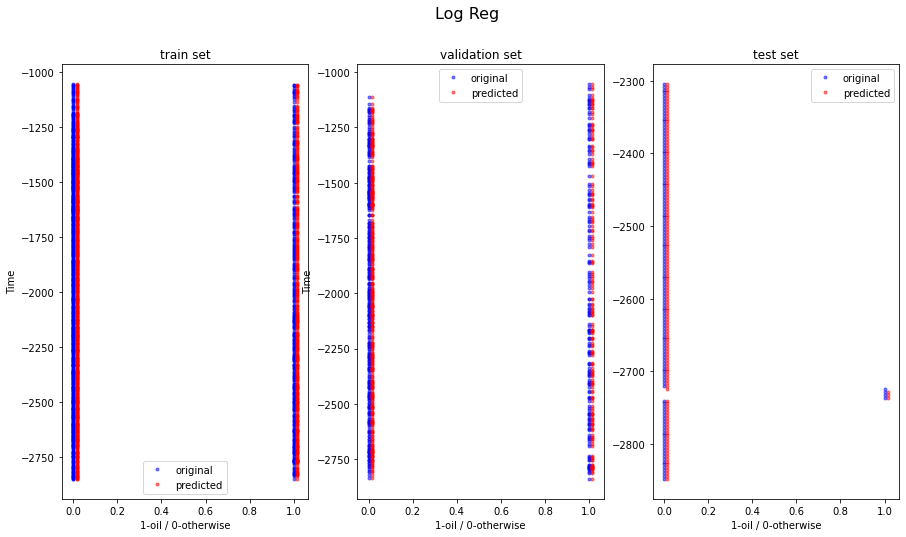

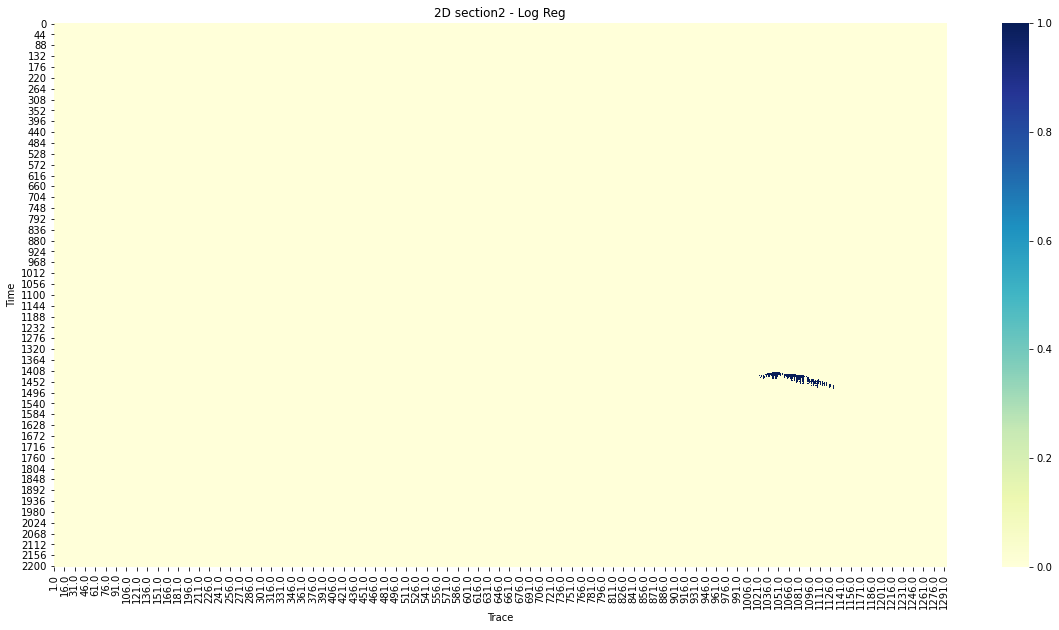

In [273]:
output_function(log_reg, 'Log Reg', X_train, y_train, X_val, y_val, X_test, y_test)

### 1.2 Grid Search for Hyperparameters tuning on Train / Validation / Test (Logistic regression) 

{'clf__C': 100, 'clf__multi_class': 'auto', 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'newton-cg'}
Precision/ Recall/ F-score on train set : 

Precision:  0.9947916666666666
Recall:  1.0
F-score:  0.9973890339425587

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.5
F-score:  0.6666666666666666


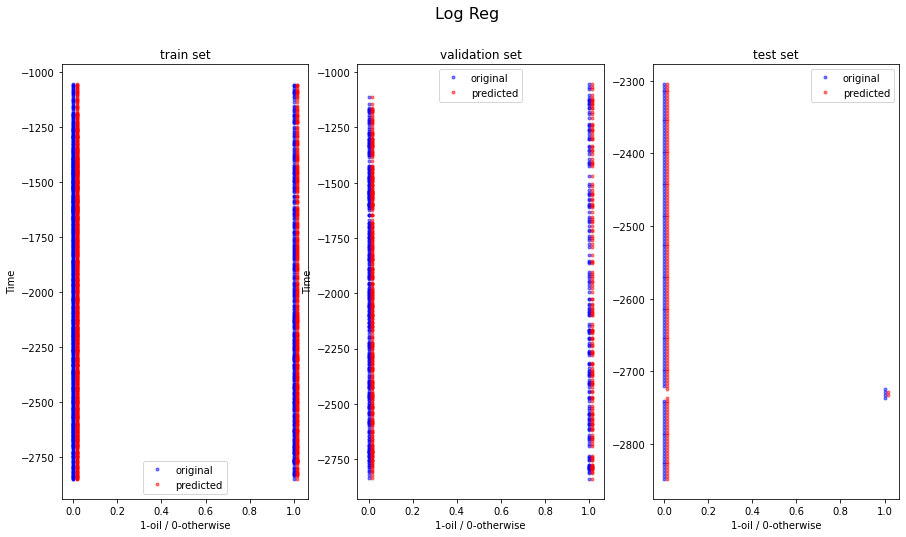

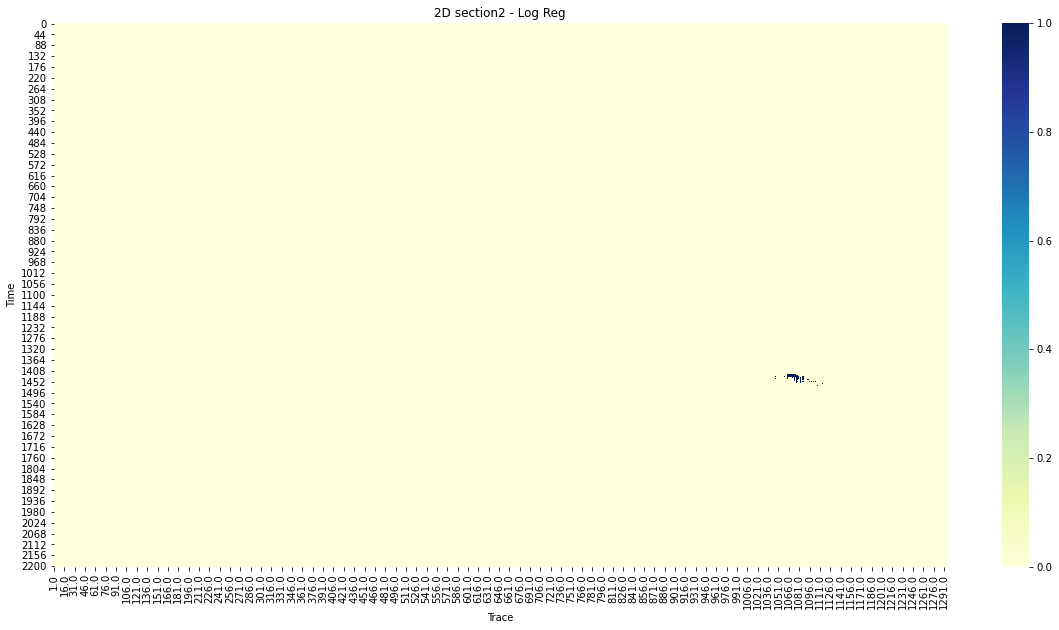

In [274]:
make_gridsearch1=True
if make_gridsearch1==True:
    cv=grid_search_function(log_reg, log_reg_params, X_train, y_train)
    output_function(cv, 'Log Reg', X_train, y_train, X_val, y_val, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'log_reg_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

### 1.3 KFold and Grid Search (Logistic Regression)

Best Hyperparameters: {'clf__C': 100, 'clf__multi_class': 'auto', 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'newton-cg'} 

Mean test score: 0.9969969482499158 

Std test score: 0.0039061981383886777 

Precision/ Recall/ F-score on train set : 

Precision:  0.9963898916967509
Recall:  1.0
F-score:  0.9981916817359855

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.5
F-score:  0.6666666666666666


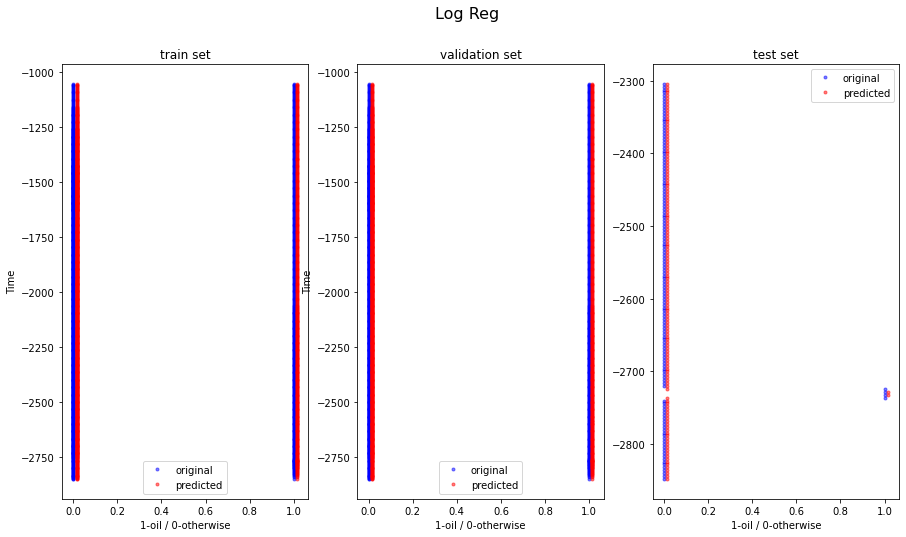

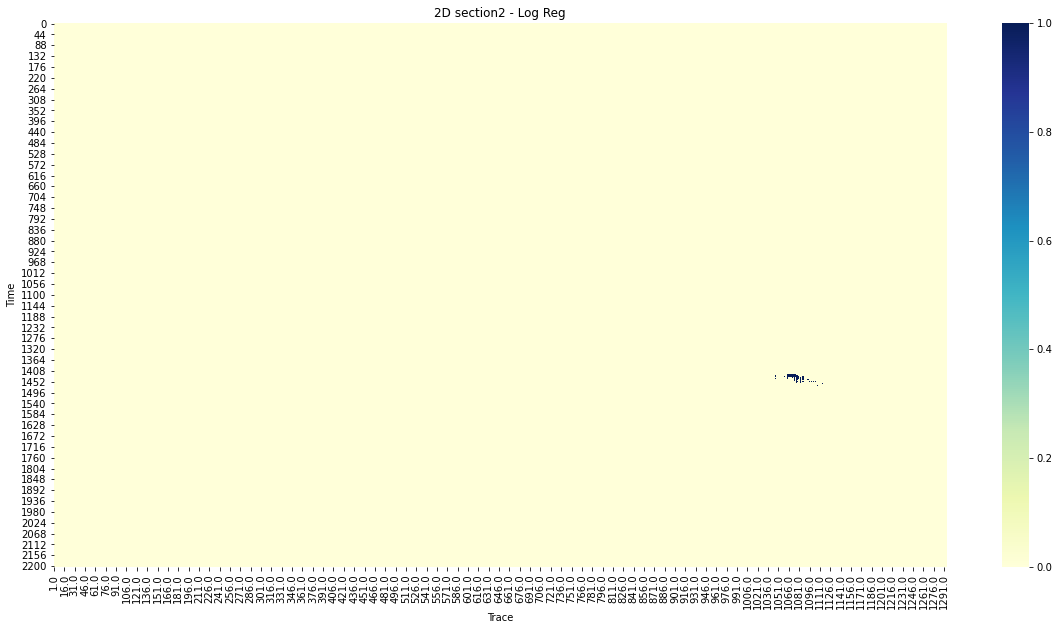

In [275]:
make_kfold1=True
if make_kfold1==True:
    result=kfold_gridsearch_function(log_reg, log_reg_params, X, Y, K_folds)
    output_function(result, 'Log Reg', X, Y, X, Y, X_test, y_test)
    
    # save model to the .pkl file
    filename = 'log_reg_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

## 2. Gaussian Naive Bayes

### 2.1 No parameters tuning

Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  0.9712041884816754
F-score:  0.9853917662682604

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  0.9647058823529412
F-score:  0.9820359281437125

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.75
F-score:  0.8571428571428571


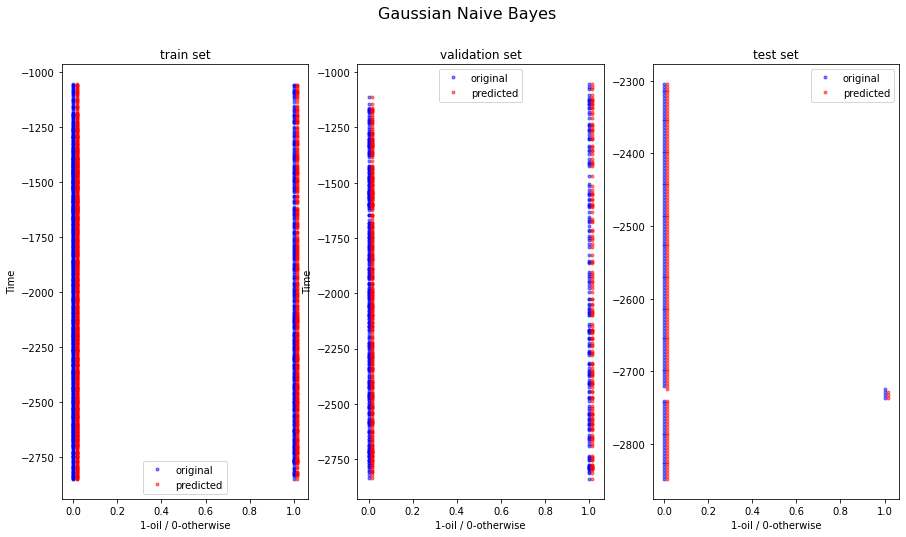

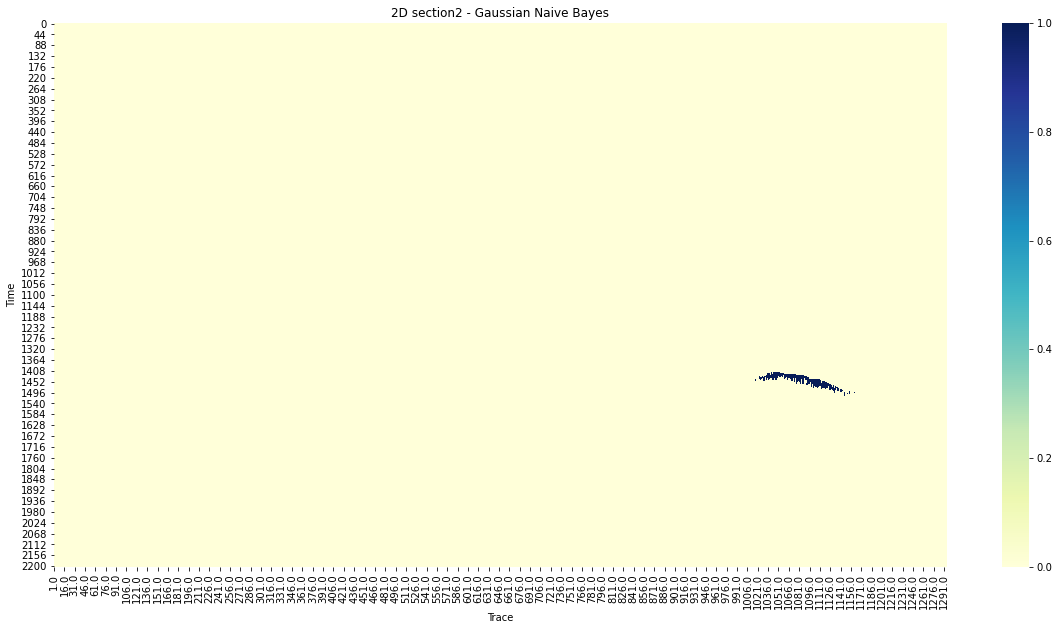

In [276]:
gnb.fit(X_train, y_train)
output_function(gnb, 'Gaussian Naive Bayes', X_train, y_train, X_val, y_val, X_test, y_test)

### 2.2 Grid search for Gaussian Naive Bayes hyperparams on Train/ Validation / Test

{'clf__var_smoothing': 1e-08}
Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  0.9712041884816754
F-score:  0.9853917662682604

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  0.9647058823529412
F-score:  0.9820359281437125

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.75
F-score:  0.8571428571428571


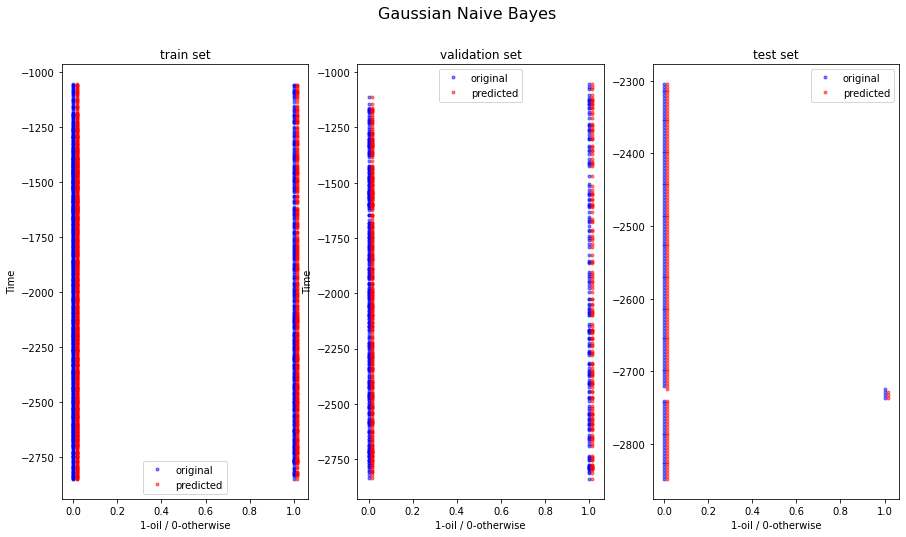

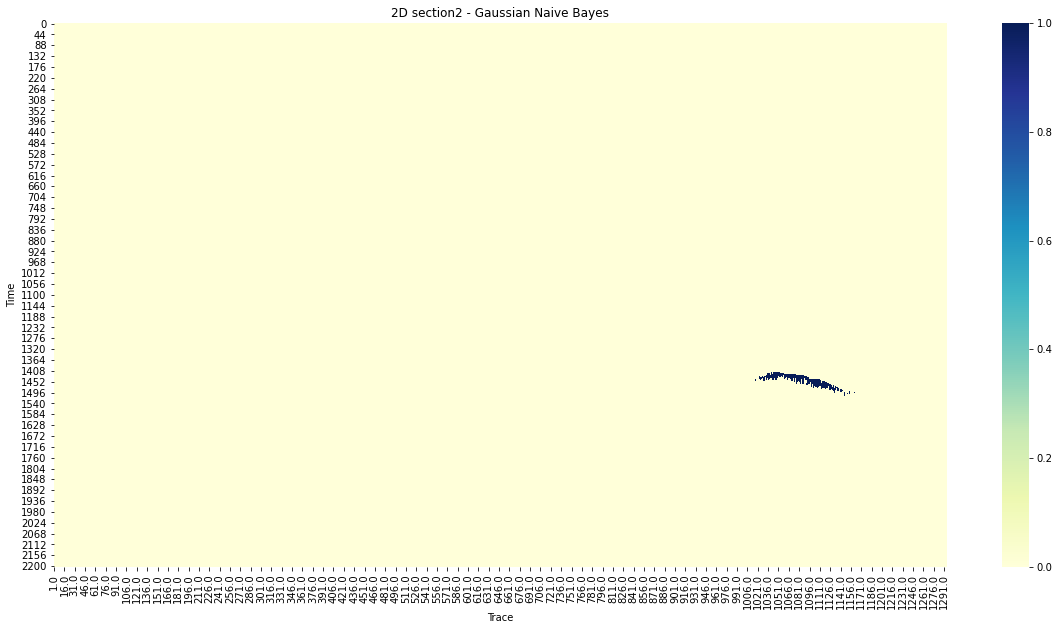

In [163]:
make_gridsearch=True
if make_gridsearch==True:
    cv=grid_search_function(gnb, gnb_params,X_train, y_train)
    output_function(cv, 'Gaussian Naive Bayes', X_train, y_train, X_val, y_val, X_test, y_test)
    
    #save model to file
    filename = 'gnb_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

### 2.3 Kfold+GridSEarch (Gaussian Naive Bayes)

Best Hyperparameters: {'clf__var_smoothing': 1e-08} 

Mean test score: 0.985542405679382 

Std test score: 0.007621955887695255 

Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  0.9710144927536232
F-score:  0.9852941176470589

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.75
F-score:  0.8571428571428571


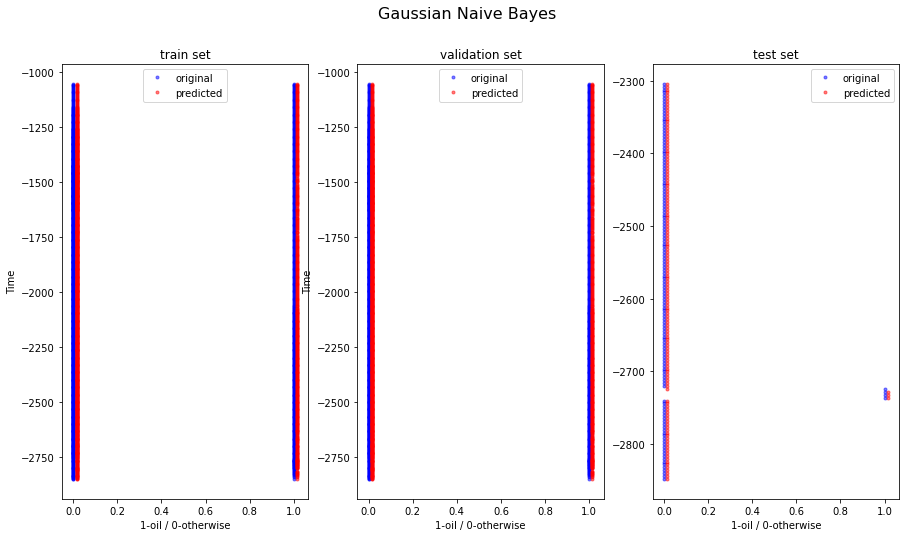

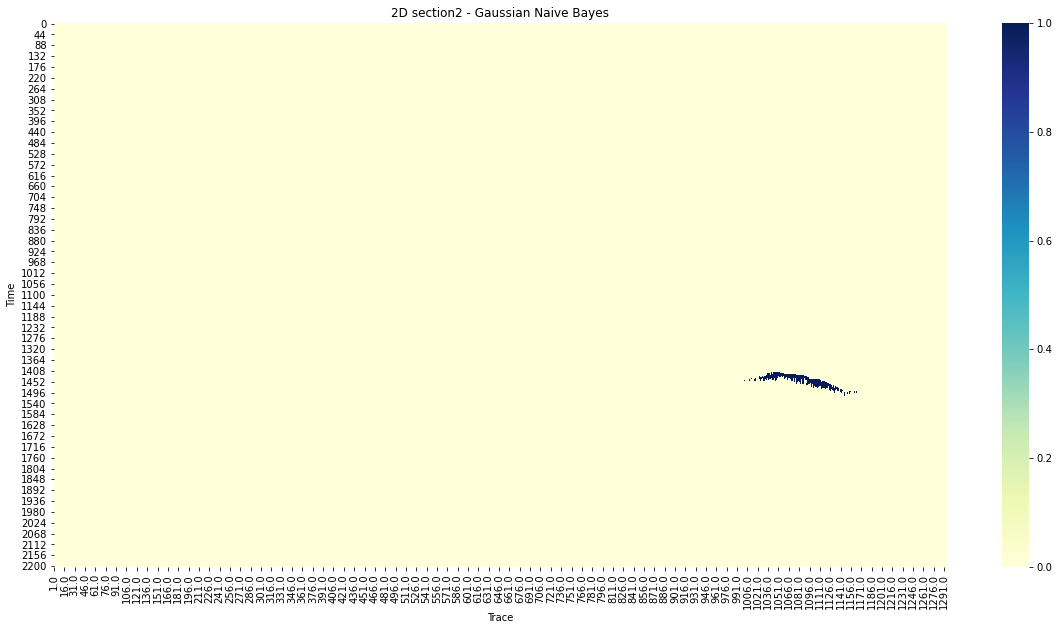

In [164]:
make_kfold=True
if make_kfold==True:
    result=kfold_gridsearch_function(gnb, gnb_params, X, Y, K_folds)
    output_function(result, 'Gaussian Naive Bayes', X, Y, X, Y, X_test, y_test)
    
    #save model to file
    filename = 'gnb_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

## 3. Support Vector Machine

### 3.1 No parameters tuning

Precision/ Recall/ F-score on train set : 

Precision:  0.9973890339425587
Recall:  1.0
F-score:  0.9986928104575163

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0


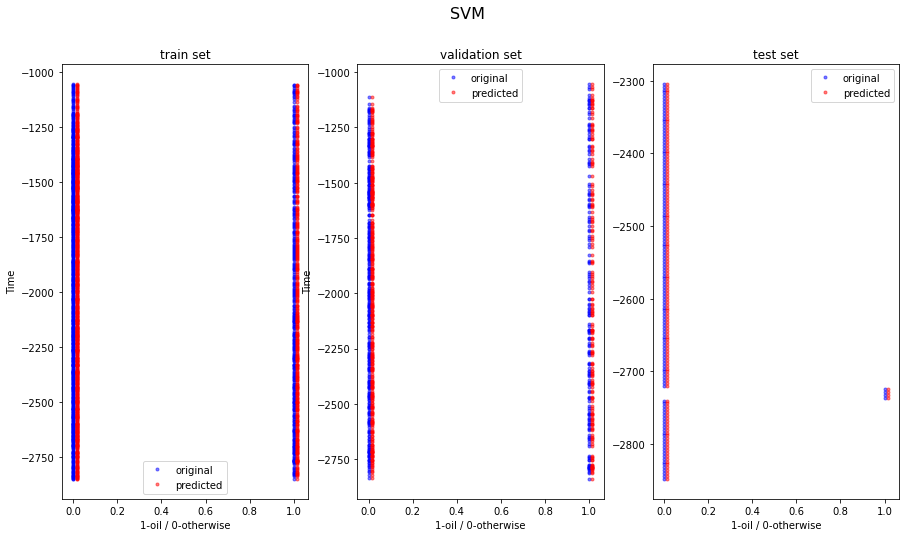

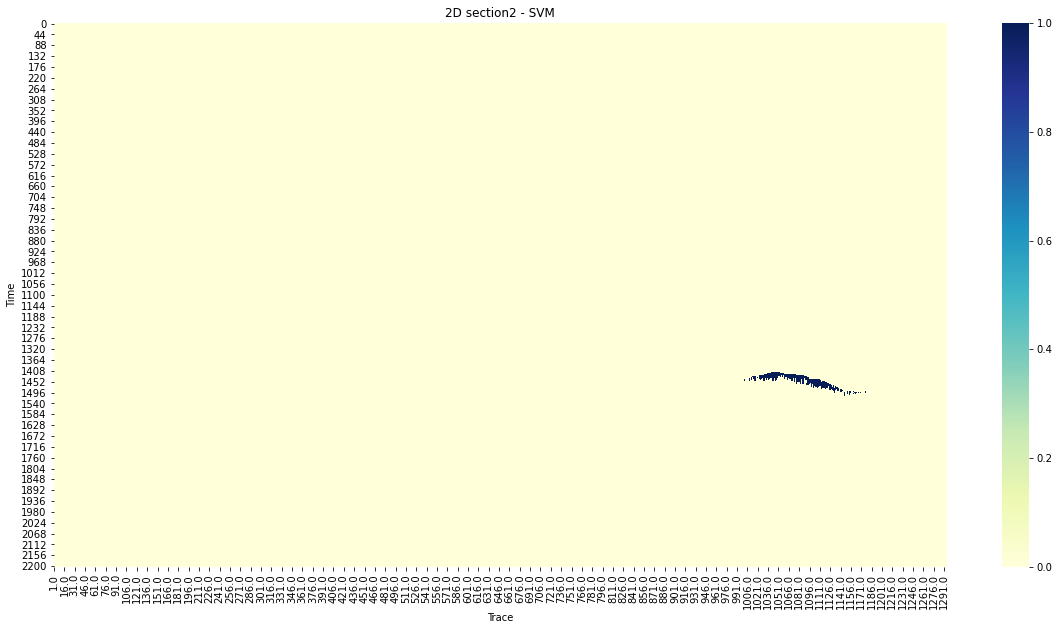

In [165]:
svm.fit(X_train, y_train)
output_function(svm, 'SVM', X_train, y_train, X_val, y_val, X_test, y_test)

### 3.2 Grid search SVM (Train/Validation/Test)

{'clf__C': 50, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.75
F-score:  0.8571428571428571


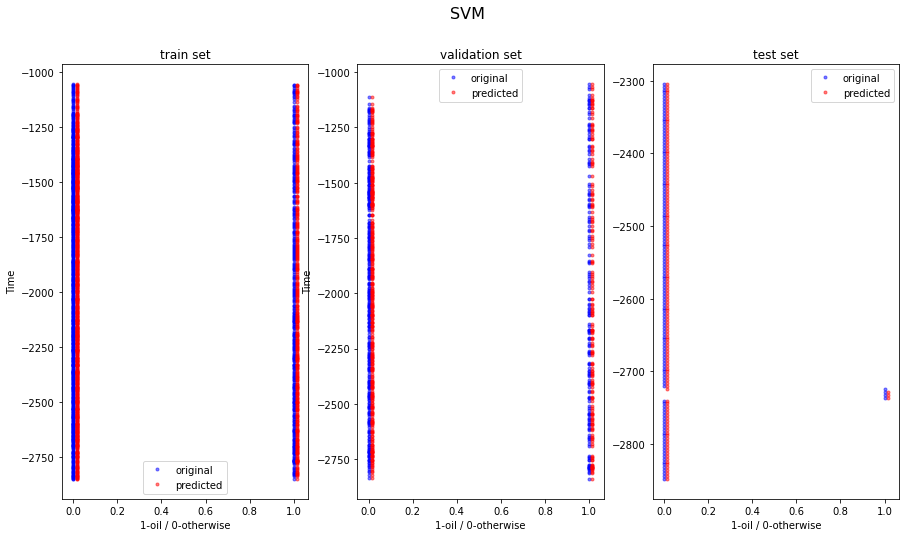

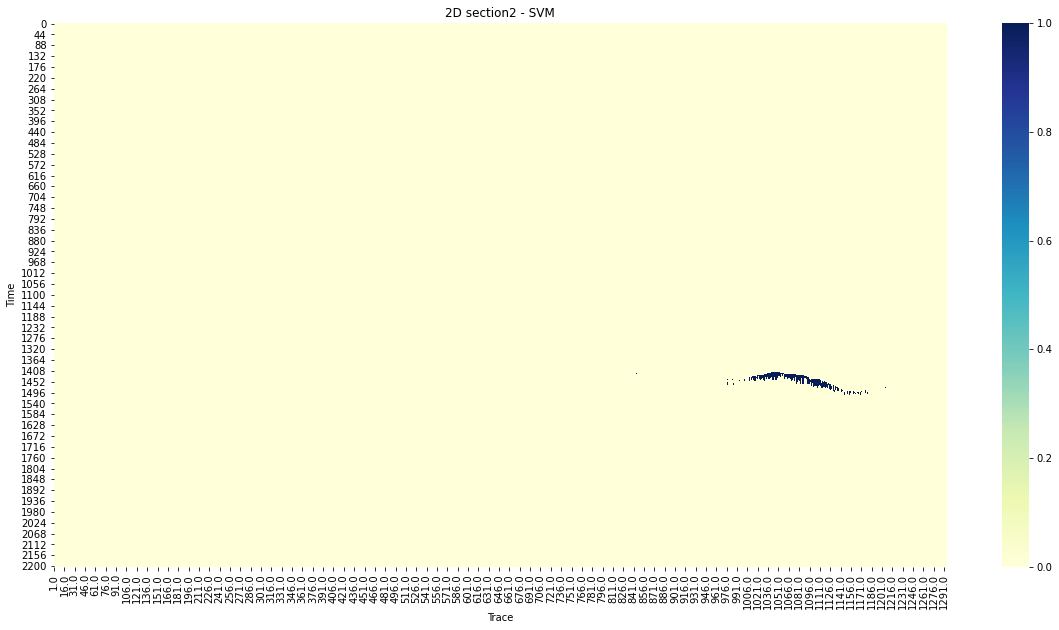

In [166]:
if make_gridsearch==True:
    cv=grid_search_function(svm, svm_params, X_train, y_train)
    output_function(cv, 'SVM', X_train, y_train, X_val, y_val, X_test, y_test)
    
    #save model to file
    filename = 'svm_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

### 3.3. Kfold + GridSearch on SVM

Best Hyperparameters: {'clf__C': 50, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'} 

Mean test score: 1.0 

Std test score: 0.0 

Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.75
F-score:  0.8571428571428571


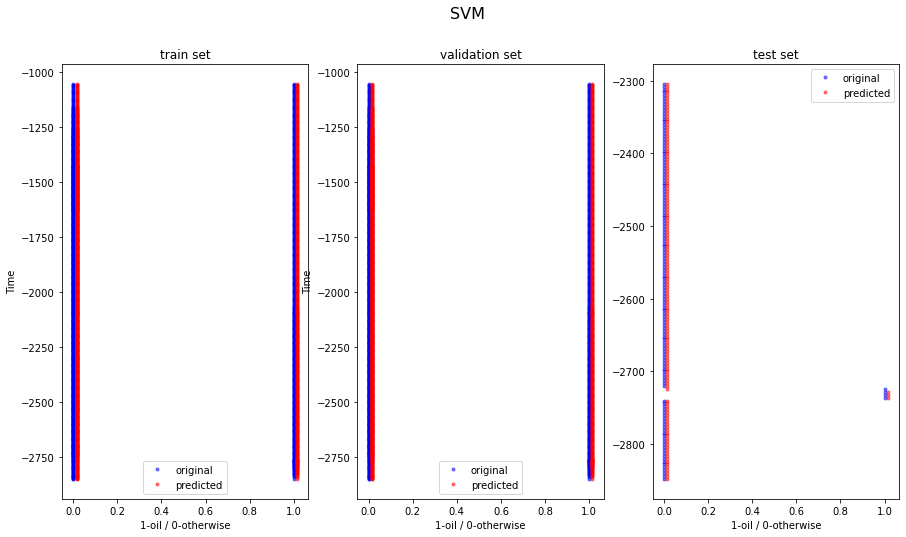

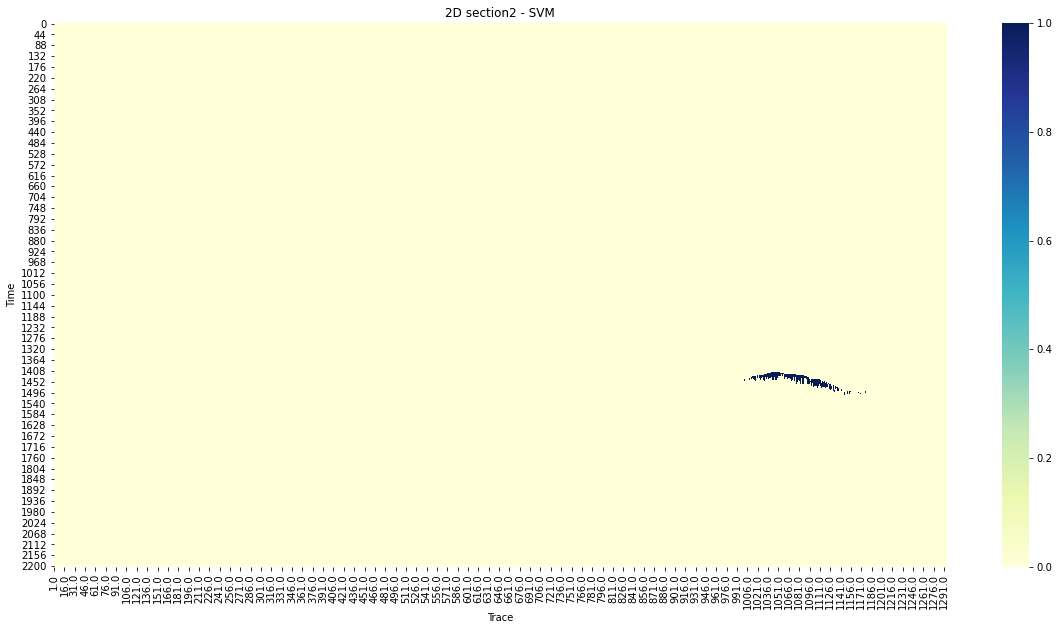

In [167]:
if make_kfold==True:
    result=kfold_gridsearch_function(svm, svm_params, X, Y, K_folds)
    output_function(result, 'SVM', X, Y, X, Y, X_test, y_test)
    
    #save model to file
    filename = 'svm_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

## 4. Gradient Boosting clf

### 4.1 No parameters tuning

Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  0.9941520467836257
Recall:  1.0
F-score:  0.9970674486803519

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.75
F-score:  0.8571428571428571


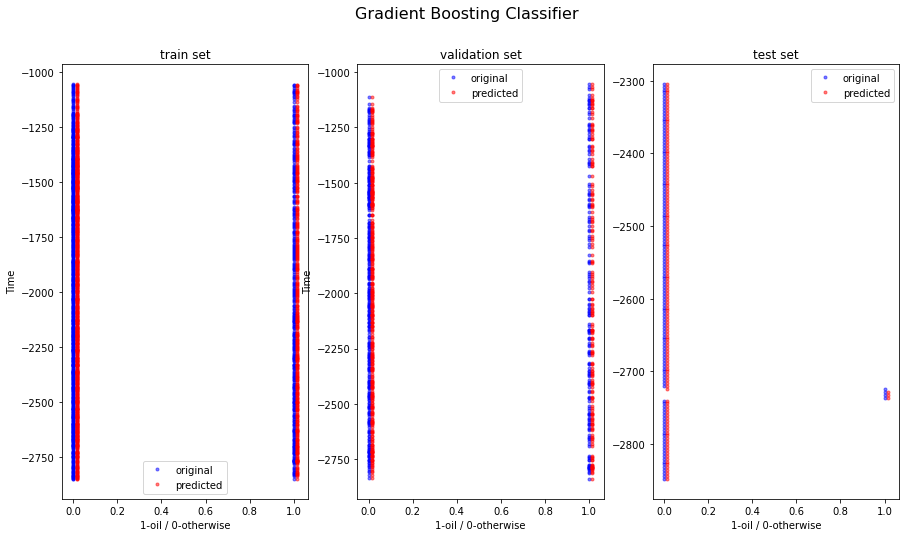

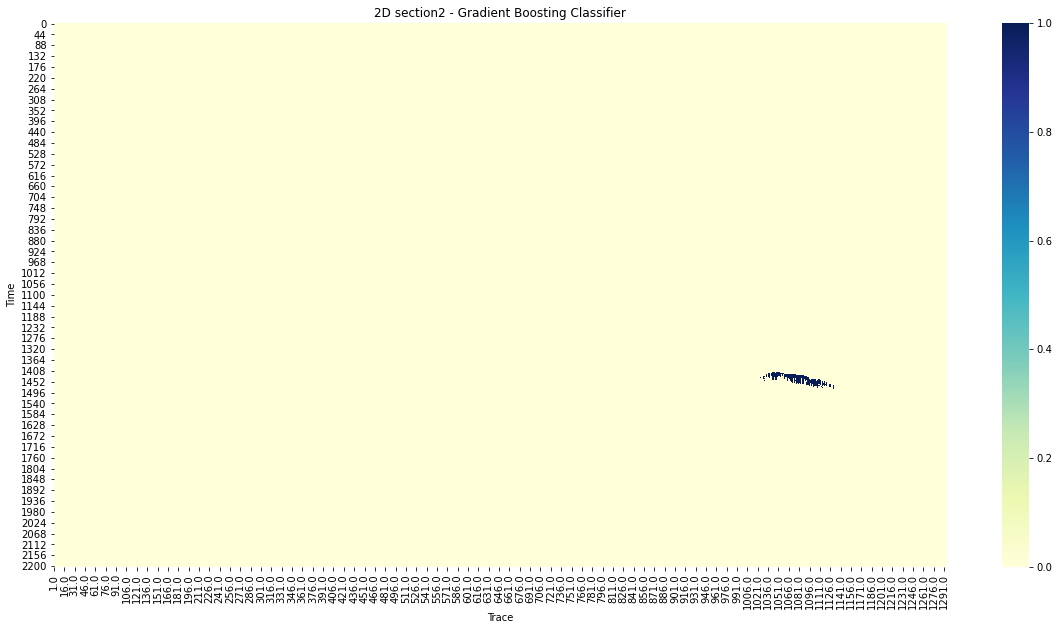

In [168]:
gbc.fit(X_train, y_train)
output_function(gbc, 'Gradient Boosting Classifier', X_train, y_train, X_val, y_val, X_test, y_test)

### 4.2 Grid Search for Gradient Boosting clf (Train/Validation/Test)

{'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 1000, 'clf__subsample': 0.5}
Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on validation set : 

Precision:  0.9941520467836257
Recall:  1.0
F-score:  0.9970674486803519

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.75
F-score:  0.8571428571428571


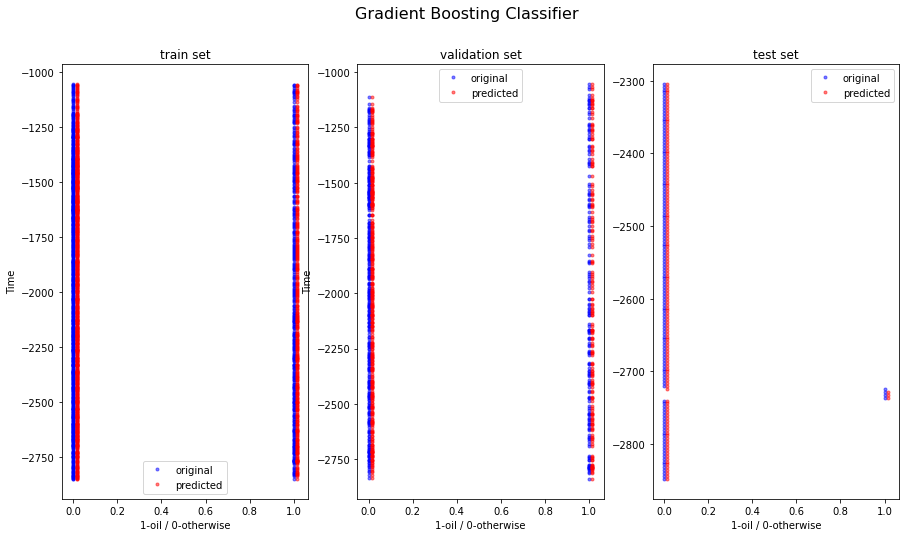

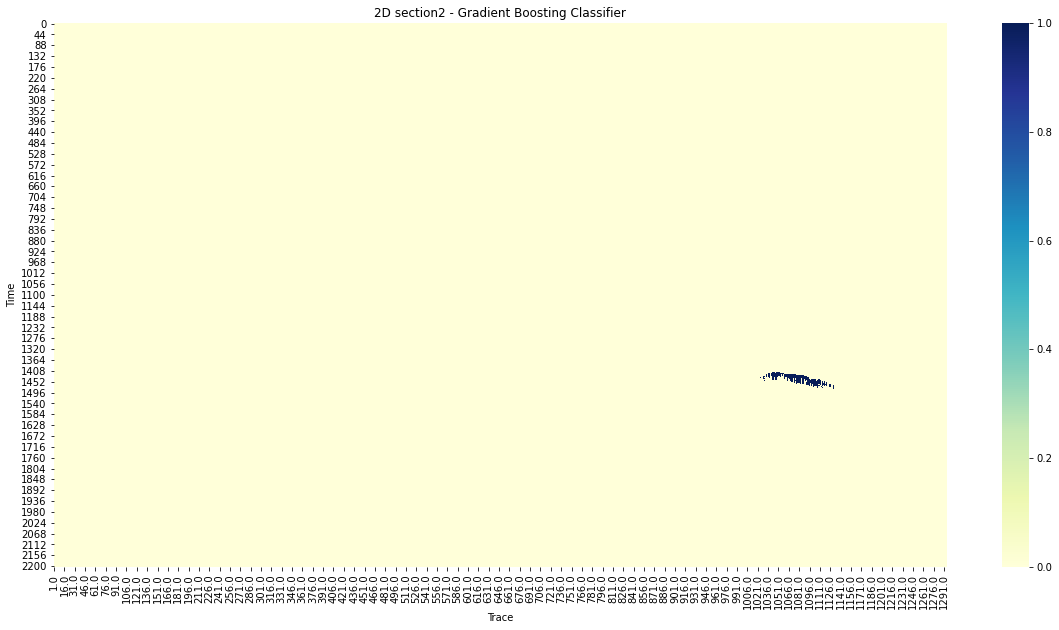

In [169]:
if make_gridsearch==True:
    cv=grid_search_function(gbc, gbc_params, X_train, y_train)
    output_function(cv, 'Gradient Boosting Classifier', X_train, y_train, X_val, y_val, X_test, y_test)
    
    #save model to file
    filename = 'gbc_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

### 4.3 Kfold + Grid Search (  Gradient Boosting Classifier)

Best Hyperparameters: {'clf__learning_rate': 0.1, 'clf__max_depth': 9, 'clf__n_estimators': 1000, 'clf__subsample': 0.5} 

Mean test score: 0.9993966817496229 

Std test score: 0.001538165765789711 

Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.75
F-score:  0.8571428571428571


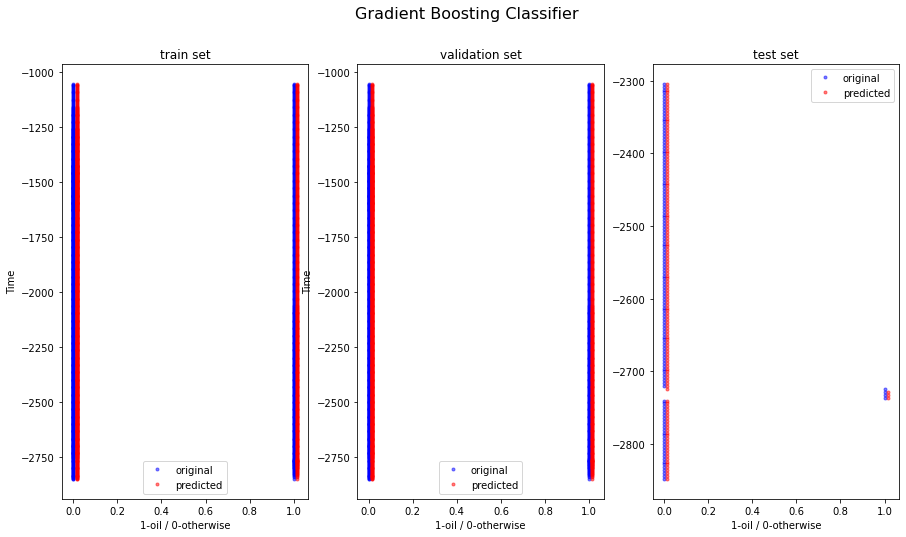

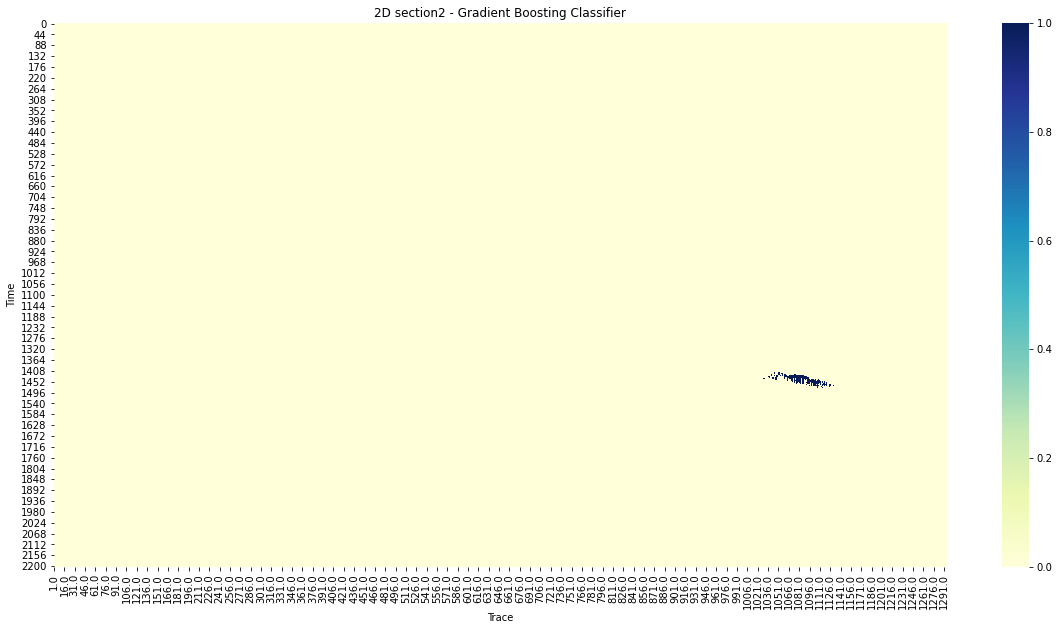

In [170]:
if make_kfold==True:
    result=kfold_gridsearch_function(gbc, gbc_params, X, Y, K_folds)
    output_function(result, 'Gradient Boosting Classifier', X, Y, X, Y, X_test, y_test)
    
    #save model to file
    filename = 'gbc_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))

## 5. MLPClassifier (Neural Network)

### 5.1 No parameters tuning

In [277]:
mlpc.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index([], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Density', 'P_wave', 'Porosity', 'Imp', 'V_clay'], dtype='object'))])),
                ('clf', MLPClassifier(random_state=42))])

Precision/ Recall/ F-score on train set : 

Precision:  0.9973890339425587
Recall:  1.0
F-score:  0.9986928104575163

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0


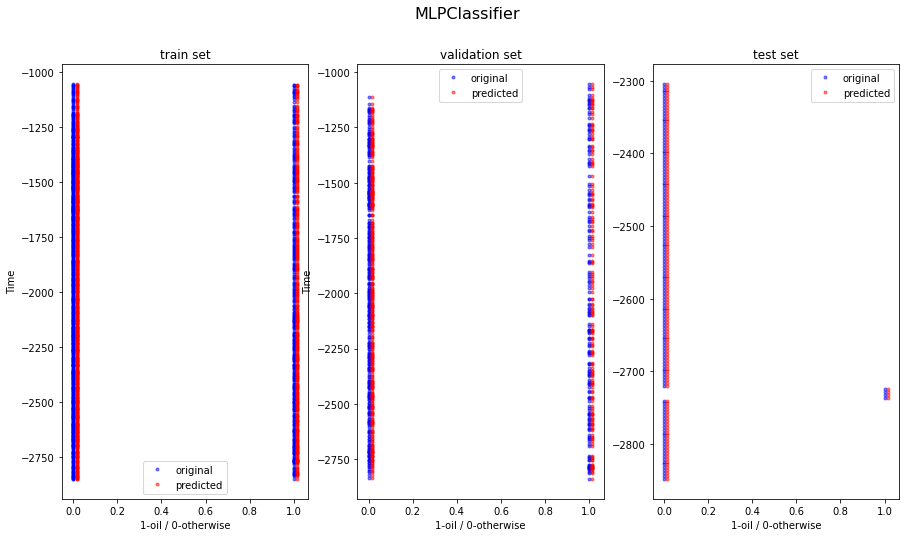

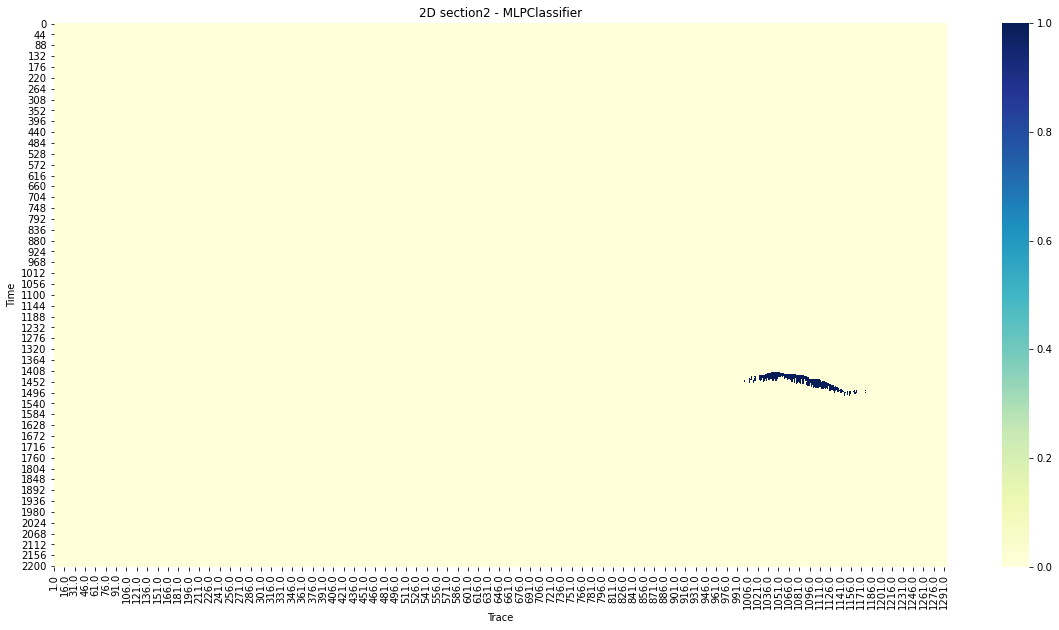

In [278]:
output_function(mlpc, 'MLPClassifier', X_train, y_train, X_val, y_val, X_test, y_test)

### 5.2 Grid Search MLPC (Train/ Validation/ test)

{'clf__activation': 'tanh', 'clf__alpha': 0.05, 'clf__batch_size': 100, 'clf__hidden_layer_sizes': (30, 10), 'clf__learning_rate': 'constant', 'clf__max_iter': 50, 'clf__momentum': True, 'clf__nesterovs_momentum': True, 'clf__random_state': 42, 'clf__solver': 'sgd'}
Precision/ Recall/ F-score on train set : 

Precision:  0.9973890339425587
Recall:  1.0
F-score:  0.9986928104575163

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  0.75
F-score:  0.8571428571428571


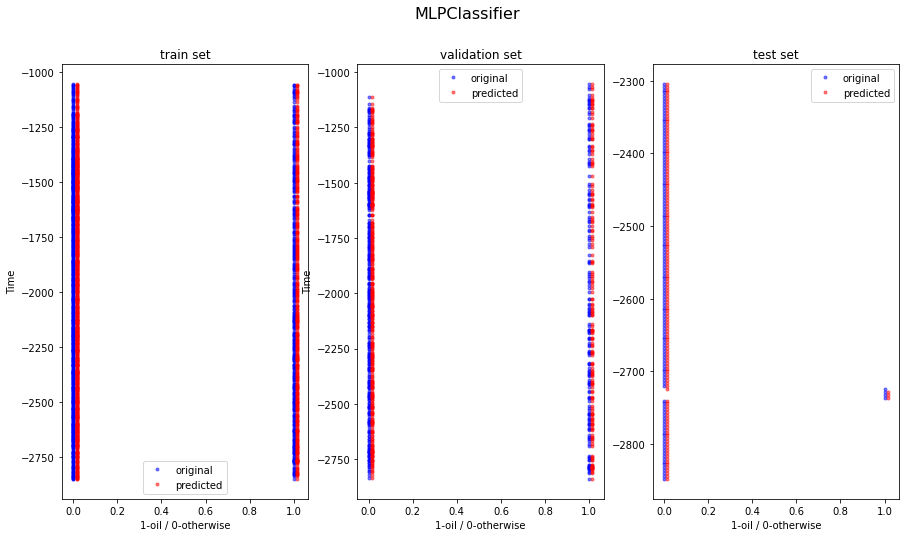

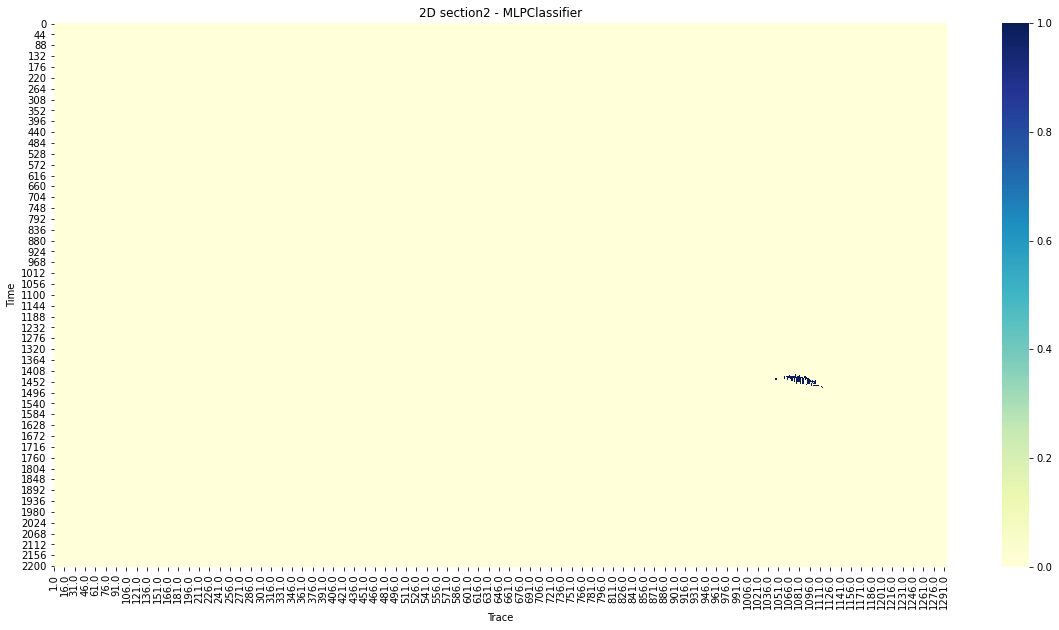

In [279]:
if make_gridsearch==True:
    cv=grid_search_function(mlpc, mlpc_params, X_train, y_train)
    output_function(cv, 'MLPClassifier', X_train, y_train, X_val, y_val, X_test, y_test)

    #save model to file
    filename = 'mlpc_gs.pkl'
    pickle.dump(cv, open(models_loc+filename, 'wb'))

### 5.3 Kfold + Grid Search (MLP classifier)

Best Hyperparameters: {'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__batch_size': 100, 'clf__hidden_layer_sizes': (60, 50, 10), 'clf__learning_rate': 'adaptive', 'clf__max_iter': 50, 'clf__momentum': True, 'clf__nesterovs_momentum': True, 'clf__random_state': 42, 'clf__solver': 'sgd'} 

Mean test score: 1.0 

Std test score: 0.0 

Precision/ Recall/ F-score on train set : 

Precision:  0.9981916817359855
Recall:  1.0
F-score:  0.9990950226244344

 Precision/ Recall/ F-score on test set : 

Precision:  1.0
Recall:  1.0
F-score:  1.0


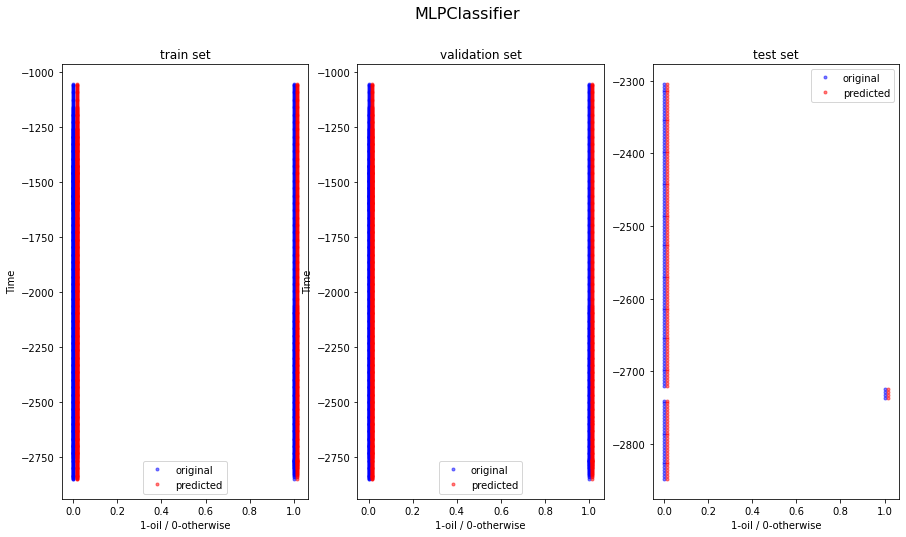

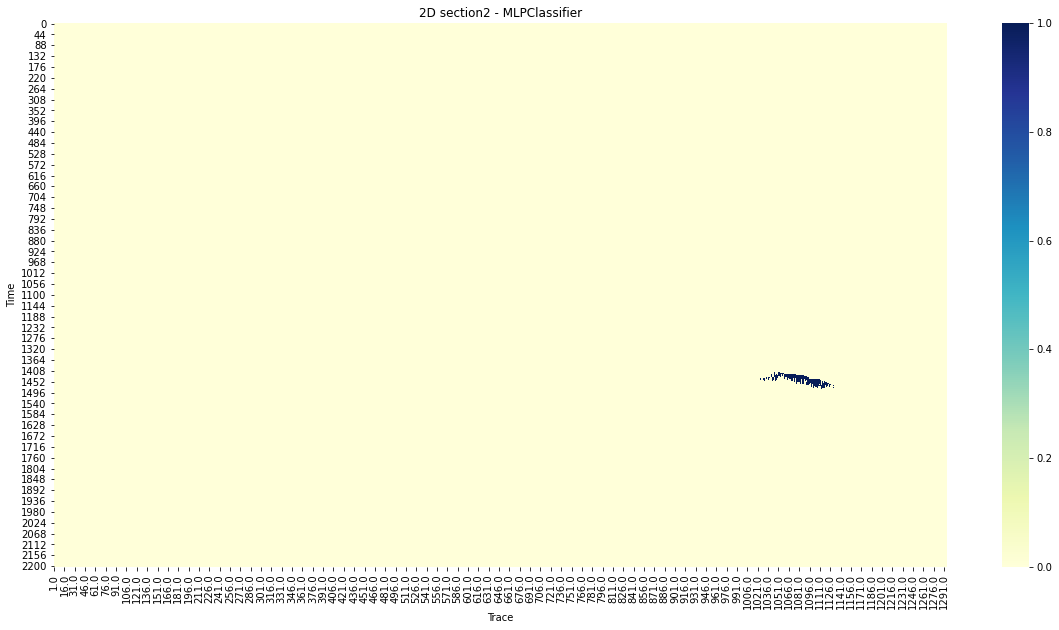

In [174]:
make_kfold=True
if make_kfold==True:
    result=kfold_gridsearch_function(mlpc, mlpc_params, X, Y, K_folds)
    output_function(result, 'MLPClassifier', X, Y, X, Y, X_test, y_test)
    
    #save model to file
    filename = 'mlpc_kfold.pkl'
    pickle.dump(result, open(models_loc+filename, 'wb'))